In [22]:
import pandas as pd 
import numpy as np 
import cv2 
import os 
from random import choice 
import matplotlib.pyplot as plt 
%matplotlib inline

In [23]:
labels = pd.read_csv('labels.csv')
labels.head(2)

,xmin,xmax,ymin,ymax,Frame,Label,Preview URL
0,785,533,905,644,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
1,89,551,291,680,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...


In [24]:
images = labels.Frame.unique()
print ('{} unique images'.format(images.shape[0]))
print ('{} labels'.format(labels.shape[0]))
print ('{} cars'.format(labels[labels.Label == 'Car'].shape[0]))
print ('{} trucks'.format(labels[labels.Label == 'Truck'].shape[0]))
print ('{} pedestrians'.format(labels[labels.Label == 'Pedestrian'].shape[0]))

9218 unique images
72064 labels
62570 cars
3819 trucks
5675 pedestrians


We are only identifying vehicles here, so drop all pedestrians. 

In [25]:
labels = labels[labels.Label != 'Pedestrian']

View some images and labels, Create Masks

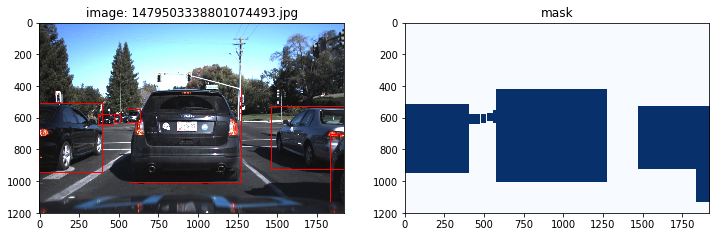

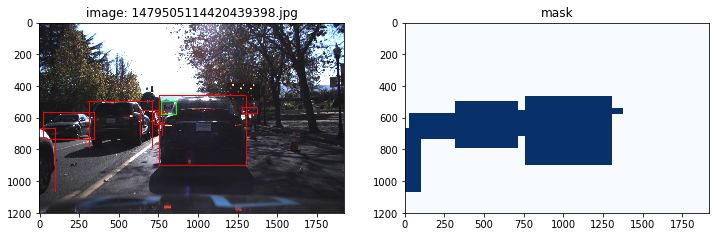

In [26]:
def show_img(id_):
    IDs = labels[labels.Frame == id_] #all IDs in that photo 
    
    im_path = os.path.join('crowdai', id_)
    img = cv2.imread(im_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    mask = np.zeros(shape=img.shape[:2])
    
    for i in range(IDs.shape[0]):
        vehicle_ID = IDs.iloc[i]
         
        if vehicle_ID.Label == 'Car': 
            color = (255, 0, 0)
            mask_color = 1
        if vehicle_ID.Label == 'Truck': 
            color = (0, 255, 0)
            mask_color = 2
        
        mask[vehicle_ID.xmax:vehicle_ID.ymax,
             vehicle_ID.xmin:vehicle_ID.ymin ] = mask_color
        
        cv2.rectangle(img,
                      (vehicle_ID.xmin, vehicle_ID.xmax),
                      (vehicle_ID.ymin, vehicle_ID.ymax),
                      color,  3, 5)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1); plt.title('image: ' + id_)
    plt.imshow(img)
    
    plt.subplot(1, 2, 2); plt.title('mask')
    plt.imshow(mask, cmap='Blues')
    plt.show()
    
for i in range(2): 
    show_img(choice(images))

Cool. Looks like we can create the masks pretty easily. I will now turn this into a Python generator, add some image augmentation functions, and have this be the input to the neural network. 

see [generator.py file](generator.py)